<a href="https://colab.research.google.com/github/peeyushsinghal/ERA/blob/main/s10/s10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchsummary

In [2]:
from __future__ import print_function
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import os

In [3]:
import albumentations as A
import numpy as np
from albumentations.pytorch.transforms import ToTensorV2

In [4]:
def apply_custom_resnet_transforms(mean,std_dev):
    train_transforms = A.Compose([A.Normalize(mean=mean, std=std_dev, always_apply=True),
                                  A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),  # padding of 4 on each side of 32x32 image
                                  A.RandomCrop(height=32, width=32, always_apply=True),
                                  A.Cutout(num_holes=1,max_h_size=8, max_w_size=8, fill_value=mean, always_apply= True),
                                  ToTensorV2()
                                 ])

    test_transforms = A.Compose([A.Normalize(mean=mean, std=std_dev, always_apply=True),
                                 ToTensorV2(),
                                 ])

    return lambda img: train_transforms(image=np.array(img))["image"], lambda img: test_transforms(image=np.array(img))["image"]

In [5]:
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
train_transforms, test_transforms = apply_custom_resnet_transforms(mean,std)
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


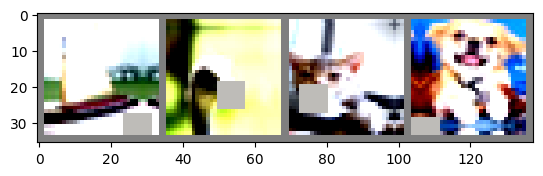

ship  bird  cat   dog  


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [8]:
import torch.nn as nn
import torch.nn.functional as F

dropout_value = 0.1
class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResBlock,self).__init__()
    self.res_block = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels = out_channels, kernel_size=3, stride =1 , padding =1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_channels, out_channels = out_channels, kernel_size=3, stride =1 , padding =1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

  def forward (self, x):
    x = self.res_block(x)
    return x


class LayerBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(LayerBlock,self).__init__()
    self.layer_block = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels = out_channels, kernel_size=3, stride =1 , padding =1),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

  def forward (self, x):
    x = self.layer_block(x)
    return x

class custom_resnet_s10(nn.Module):
  def __init__(self, num_classes=10):
    super(custom_resnet_s10,self).__init__()

    self.PrepLayer = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels=64, kernel_size = 3, stride = 1, padding =1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
    )
    self.Layer1 = LayerBlock(in_channels = 64, out_channels=128)
    self.resblock1 = ResBlock(in_channels =128, out_channels=128)
    self.Layer2 = LayerBlock(in_channels = 128, out_channels=256)
    self.resblock2 = ResBlock(in_channels =256, out_channels=256)
    self.Layer3 = LayerBlock(in_channels = 256, out_channels=512)
    self.resblock3 = ResBlock(in_channels =512, out_channels=512)
    self.max_pool4 = nn.MaxPool2d(kernel_size=4, stride=4) # 512,512, 4/4 = 512,512,1
    self.fc = nn.Linear(512,num_classes)

  def forward(self,x):
    x = self.PrepLayer(x)
    #################
    x = self.Layer1(x)
    # print("x..l1",x.shape)
    resl1 = self.resblock1(x)
    # print("resl1",resl1.shape)
    x = x+resl1
    # print("x..l1+resl1",x.shape)
    #################
    x = self.Layer2(x)
    # print("x..l2",x.shape)
    resl2 = self.resblock2(x)
    # print("resl2",resl2.shape)
    x = x+resl2
    # print("x..l2+resl2",x.shape)
    #################
    x = self.Layer3(x)
    # print("x..l3",x.shape)
    resl3 = self.resblock3(x)
    # print("resl3",resl3.shape)
    x = x+resl3
    # print("x..l3+resl3",x.shape)
    #################
    x = self.max_pool4(x)
    # print("x..max_pool4",x.shape)
    x = x.view(x.size(0),-1)
    # print("x..flat",x.shape)
    x = self.fc(x)
    return F.log_softmax(x, dim=-1)

In [9]:
# Net = custom_resnet_s10()
# rand_img = torch.rand(1,3,32,32)
# Net(rand_img)

In [10]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = custom_resnet_s10().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
        LayerBlock-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1,

In [17]:
import torch
import torch.nn as nn
from tqdm import tqdm # for beautiful model training updates


def trainer(model,device, trainloader, testloader, optimizer,epochs,criterion,scheduler):
  train_losses = [] # to capture train losses over training epochs
  train_accuracy = [] # to capture train accuracy over training epochs
  test_losses = [] # to capture test losses
  test_accuracy = [] # to capture test accuracy
  for epoch in range(epochs):
    print("EPOCH:", epoch+1)
    train(model, device, trainloader, optimizer, epoch,criterion,train_accuracy,train_losses,scheduler) # Training Function
    test(model, device, testloader,criterion,test_accuracy,test_losses)   # Test Function

  return train_accuracy, train_losses, test_accuracy, test_losses


# # Training Function
def train(model, device, train_loader, optimizer, epoch,criterion,train_accuracy,train_losses,scheduler = None):
  model.train() # setting the model in training
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = criterion(y_preds,labels) # capturing loss

    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    if scheduler:
      if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step()

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)


    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_accuracy.append(100*correct/processed)


# # Test Function
def test(model, device, test_loader,criterion,test_accuracy,test_losses) :
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector

      test_loss = criterion(outputs,labels).item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))

### One Cycle LR

In [12]:
import copy
model_oclr = copy.deepcopy(model)
model_oclr = model_oclr.to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_oclr.parameters(), lr=0.01)

In [14]:
! pip install torch_lr_finder

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.16E+00


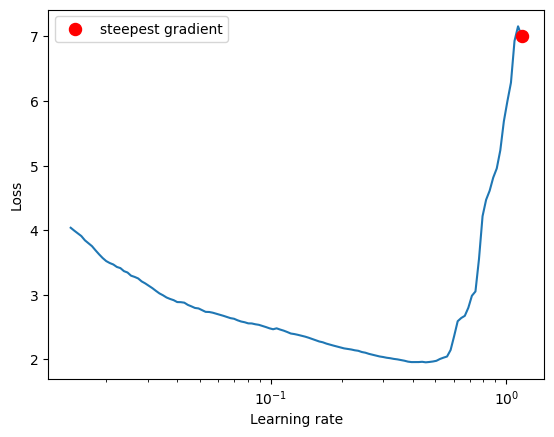

In [15]:
from torch_lr_finder import LRFinder
from tqdm.autonotebook import tqdm

lr_finder = LRFinder(model_oclr, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

### Training

In [16]:
max_lr = 1.16
EPOCHS = 24
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=float(max_lr),
                                                steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS,
                                                pct_start=(5/24),## how much percent of cycle to use for building up
                                                div_factor=10,## initial lr max/div_factor
                                                three_phase=False, ## no annihilation
                                                final_div_factor=50,## min lr max/div_factor
                                                anneal_strategy='linear'
                                                )

In [18]:
 model = model.to(device)

 train_accuracy, train_losses, test_accuracy, test_losses = trainer(model = model,
                                                                    device = device,
                                                                    trainloader = train_loader,
                                                                    testloader = test_loader,
                                                                    optimizer = optimizer,
                                                                    epochs = EPOCHS,
                                                                    criterion = criterion,
                                                                    scheduler= scheduler)

EPOCH: 1


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.438926339149475 Batch_id=97 Accuracy=34.96: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]



Test set: Average loss: 0.0001, Accuracy: 4995/10000 (49.95%)

EPOCH: 2


Loss=1.057191252708435 Batch_id=97 Accuracy=55.33: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]



Test set: Average loss: 0.0002, Accuracy: 5449/10000 (54.49%)

EPOCH: 3


Loss=0.8681988716125488 Batch_id=97 Accuracy=66.40: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]



Test set: Average loss: 0.0001, Accuracy: 6649/10000 (66.49%)

EPOCH: 4


Loss=0.7527937293052673 Batch_id=97 Accuracy=74.59: 100%|██████████| 98/98 [00:27<00:00,  3.59it/s]



Test set: Average loss: 0.0001, Accuracy: 7098/10000 (70.98%)

EPOCH: 5


Loss=0.6469466090202332 Batch_id=97 Accuracy=78.71: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]



Test set: Average loss: 0.0001, Accuracy: 7887/10000 (78.87%)

EPOCH: 6


Loss=0.4306267201900482 Batch_id=97 Accuracy=82.31: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]



Test set: Average loss: 0.0001, Accuracy: 7997/10000 (79.97%)

EPOCH: 7


Loss=0.3398405909538269 Batch_id=97 Accuracy=85.38: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]



Test set: Average loss: 0.0000, Accuracy: 8277/10000 (82.77%)

EPOCH: 8


Loss=0.3425373435020447 Batch_id=97 Accuracy=87.06: 100%|██████████| 98/98 [00:28<00:00,  3.43it/s]



Test set: Average loss: 0.0000, Accuracy: 8476/10000 (84.76%)

EPOCH: 9


Loss=0.3593102693557739 Batch_id=97 Accuracy=89.37: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]



Test set: Average loss: 0.0000, Accuracy: 8384/10000 (83.84%)

EPOCH: 10


Loss=0.33744436502456665 Batch_id=97 Accuracy=90.30: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]



Test set: Average loss: 0.0000, Accuracy: 8582/10000 (85.82%)

EPOCH: 11


Loss=0.2301202267408371 Batch_id=97 Accuracy=92.09: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]



Test set: Average loss: 0.0000, Accuracy: 8760/10000 (87.60%)

EPOCH: 12


Loss=0.22093932330608368 Batch_id=97 Accuracy=93.02: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]



Test set: Average loss: 0.0001, Accuracy: 8526/10000 (85.26%)

EPOCH: 13


Loss=0.1260785311460495 Batch_id=97 Accuracy=94.05: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]



Test set: Average loss: 0.0000, Accuracy: 8676/10000 (86.76%)

EPOCH: 14


Loss=0.13487374782562256 Batch_id=97 Accuracy=95.05: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s]



Test set: Average loss: 0.0000, Accuracy: 8900/10000 (89.00%)

EPOCH: 15


Loss=0.12782709300518036 Batch_id=97 Accuracy=95.94: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average loss: 0.0000, Accuracy: 8837/10000 (88.37%)

EPOCH: 16


Loss=0.0989096388220787 Batch_id=97 Accuracy=96.44: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]



Test set: Average loss: 0.0000, Accuracy: 8996/10000 (89.96%)

EPOCH: 17


Loss=0.05447838827967644 Batch_id=97 Accuracy=97.20: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]



Test set: Average loss: 0.0000, Accuracy: 9018/10000 (90.18%)

EPOCH: 18


Loss=0.07322374731302261 Batch_id=97 Accuracy=97.63: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]



Test set: Average loss: 0.0000, Accuracy: 9093/10000 (90.93%)

EPOCH: 19


Loss=0.02914329618215561 Batch_id=97 Accuracy=97.99: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]



Test set: Average loss: 0.0000, Accuracy: 9060/10000 (90.60%)

EPOCH: 20


Loss=0.04158638417720795 Batch_id=97 Accuracy=98.47: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]



Test set: Average loss: 0.0000, Accuracy: 9076/10000 (90.76%)

EPOCH: 21


Loss=0.023691503331065178 Batch_id=97 Accuracy=98.71: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]



Test set: Average loss: 0.0000, Accuracy: 9132/10000 (91.32%)

EPOCH: 22


Loss=0.020311063155531883 Batch_id=97 Accuracy=99.09: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]



Test set: Average loss: 0.0000, Accuracy: 9162/10000 (91.62%)

EPOCH: 23


Loss=0.011509985662996769 Batch_id=97 Accuracy=99.22: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s]



Test set: Average loss: 0.0000, Accuracy: 9182/10000 (91.82%)

EPOCH: 24


Loss=0.03191109374165535 Batch_id=97 Accuracy=99.33: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]



Test set: Average loss: 0.0000, Accuracy: 9199/10000 (91.99%)



## Assessing training and output

In [19]:
import seaborn as sns

def plot_metrics(train_accuracy, train_losses, test_accuracy, test_losses):
    sns.set(font_scale=1)
    plt.rcParams["figure.figsize"] = (25,6)

    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(train_losses), 'b', label="Train Loss")

    # Label the plot.
    ax1.set_title("Train Loss")
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(np.array(train_accuracy), 'b', label="Train Accuracy")

    # Label the plot.
    ax2.set_title("Train Accuracy")
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Loss")
    ax2.legend()

    plt.show()

    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(test_losses), 'b', label="Test Loss")

    # Label the plot.
    ax1.set_title("Test Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(np.array(test_accuracy), 'b', label="Test Accuracy")

    # Label the plot.
    ax2.set_title("Test Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()

    plt.show()

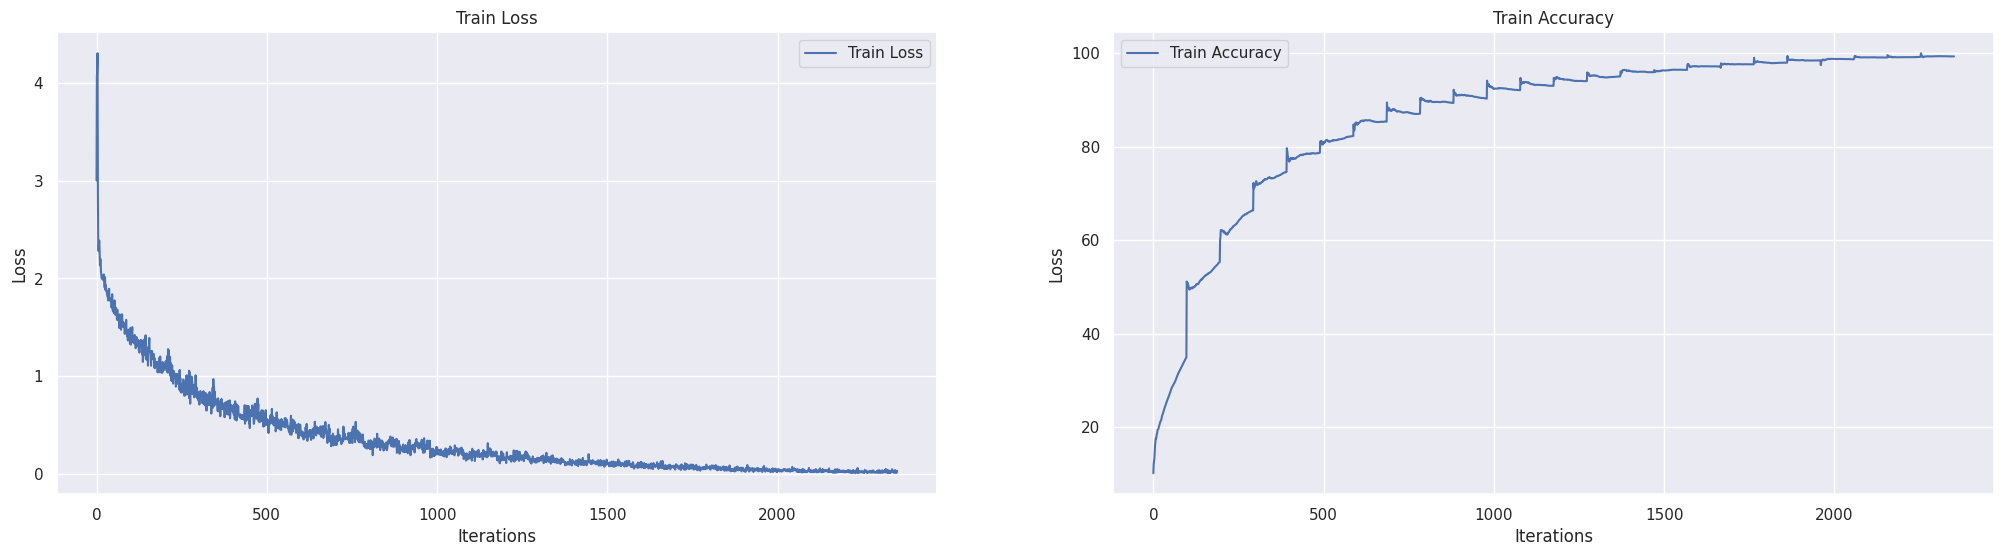

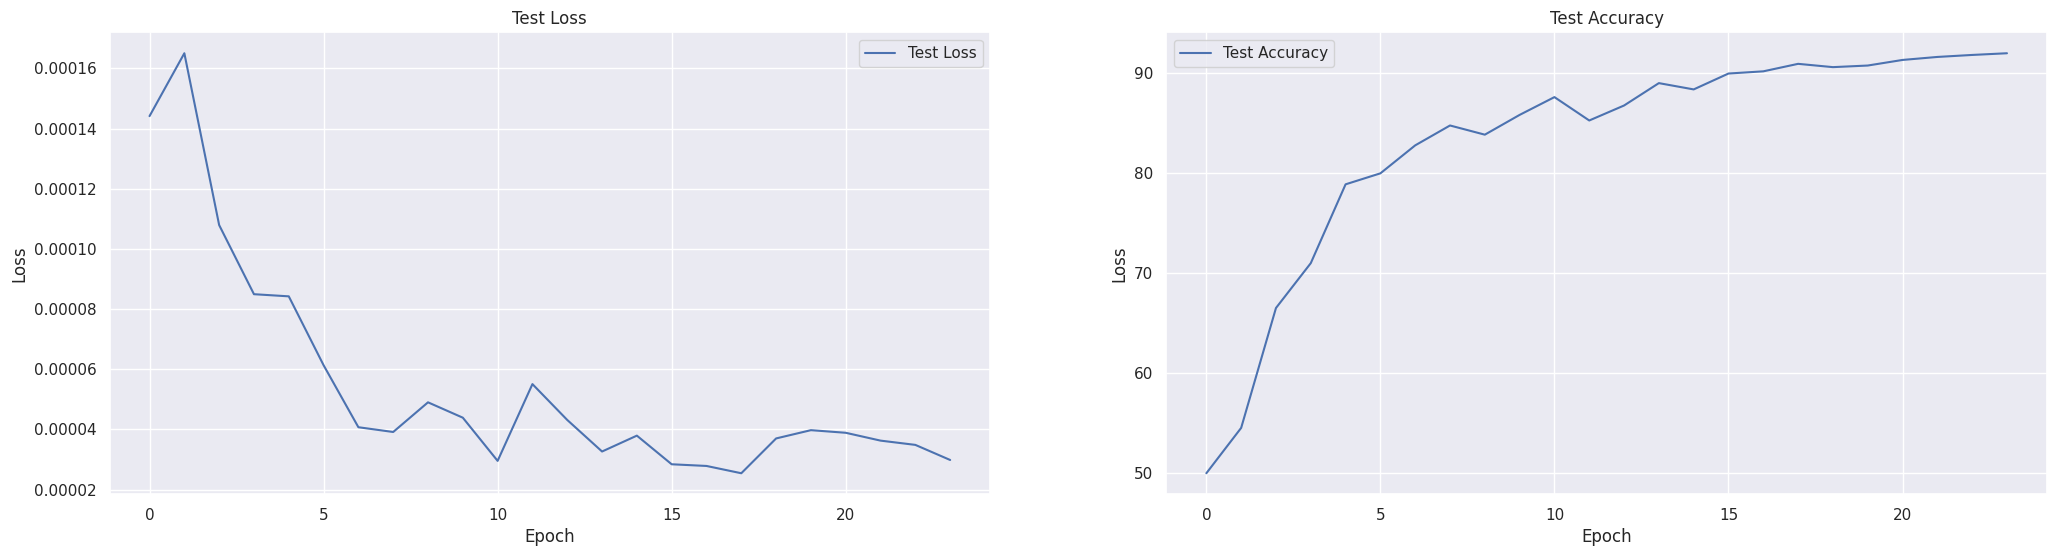

In [20]:
plot_metrics(train_accuracy, [x.cpu().detach().numpy() for x in train_losses], test_accuracy, test_losses)


In [21]:
def evaluate_classwise_accuracy(model, device, classes, test_loader):
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
            	label = labels[i]
            	class_correct[label] += c[i].item()
            	class_total[label] += 1

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [22]:
evaluate_classwise_accuracy(model, device, classes, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of plane : 87 %
Accuracy of   car : 100 %
Accuracy of  bird : 90 %
Accuracy of   cat : 85 %
Accuracy of  deer : 90 %
Accuracy of   dog : 100 %
Accuracy of  frog : 75 %
Accuracy of horse : 88 %
Accuracy of  ship : 100 %
Accuracy of truck : 90 %


## Misclasssified Images

In [23]:
def plot_misclassified_images(wrong_predictions, mean, std, n_images=20, class_names=None):
    """
    Plot the misclassified images.
    """
    if class_names is None:
        class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    fig = plt.figure(figsize=(10, 12))
    fig.tight_layout()
    for i, (img, pred, correct) in enumerate(wrong_predictions[:n_images]):
        img, pred, target = img.cpu().numpy().astype(dtype=np.float32), pred.cpu(), correct.cpu()
        for j in range(img.shape[0]):
            img[j] = (img[j] * std[j]) + mean[j]

        img = np.transpose(img, (1, 2, 0))
        ax = fig.add_subplot(5, 5, i + 1)
        ax.axis("off")
        ax.set_title(f"\nactual : {class_names[target.item()]}\npredicted : {class_names[pred.item()]}", fontsize=10)
        ax.imshow(img)

    plt.show()

def misclassified_images(model, test_loader, device, mean, std, class_names=None, n_images=20):
    """
    Get misclassified images.
    """
    wrong_images = []
    wrong_label = []
    correct_label = []
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True).squeeze()  # get the index of the max log-probability

            wrong_pred = pred.eq(target.view_as(pred)) == False
            wrong_images.append(data[wrong_pred])
            wrong_label.append(pred[wrong_pred])
            correct_label.append(target.view_as(pred)[wrong_pred])

            wrong_predictions = list(zip(torch.cat(wrong_images), torch.cat(wrong_label), torch.cat(correct_label)))
        print(f"Total wrong predictions are {len(wrong_predictions)}")

        plot_misclassified_images(wrong_predictions, mean, std, n_images=n_images, class_names=class_names)

    return wrong_predictions



Total wrong predictions are 801


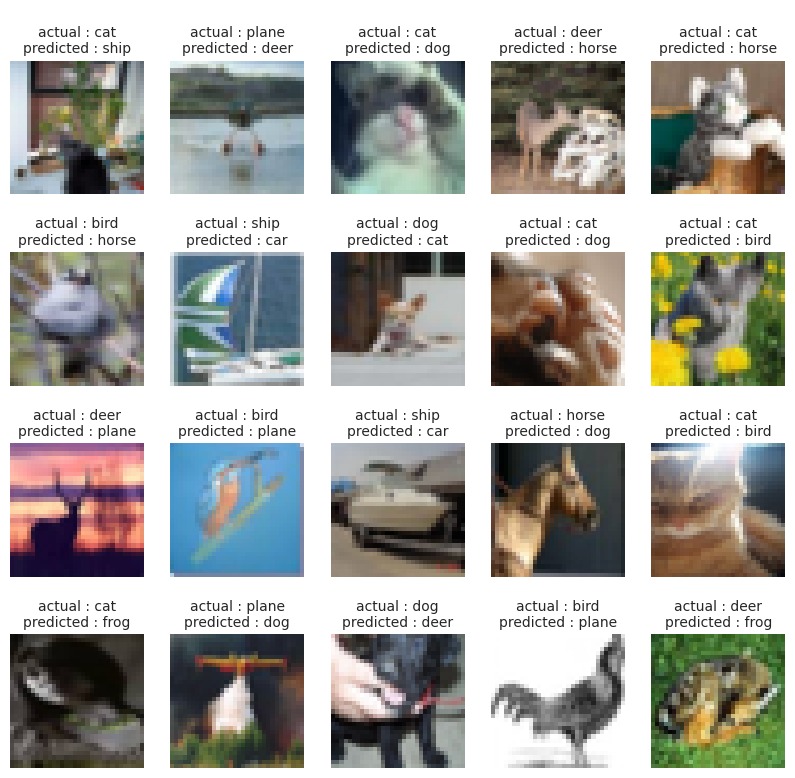

In [24]:
images_misclassified = misclassified_images(model, test_loader, device, mean, std , class_names=classes)